In [26]:
#IMPORTS
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import networkx as nx
from tkinter import *
from tkinter import ttk
import json

In [27]:
#BFS

visited = []  # List for visited nodes.
queue = []  # Initialize a queue

def bfs(visited, graph, node):  # function for BFS

    
    visited.append(node)
    queue.append(node)
  
    
    while queue:  # Creating loop to visit each node
        m = queue.pop(0)
        print(m, end=" ")

        for neighbour in graph[m]:
            if neighbour not in visited:
                visited.append(neighbour)
                queue.append(neighbour)


# Driver Code
print("Following is the Breadth-First Search")
bfs(visited, graph, "A")  # function calling

Following is the Breadth-First Search


NameError: name 'graph' is not defined

In [34]:
graph_problem = {}   
unpacked_keys = []
unpacked_values = []

def draw_state():

    options = {'edge_color':"grey",'node_color': 'gold','node_size': 100,'width': 1}
    
    # creates a copy of the graph without any blanks
    graph_cleaned = remove_blanks(graph_problem)
    
    graph_plot.cla()  
    

    #graph_plot.axis('off')
    
    #undirected graph
    G = nx.Graph(graph_cleaned)
    nx.draw(G,with_labels = True,ax=graph_plot, **options)  
    graph_figure.set_facecolor("#f0f0f0")
    
    #set margins so nodes arent clipped
    ax = plt.gca()
    ax.margins(1)
    plt.axis("off")
    plt.show()
    
    graph_canvas.draw()
    graph_canvas.get_tk_widget().grid()

    
    total_edges = "Total edges: " + str(G.number_of_edges())
    number_edges.config(text=total_edges)
    
    total_vertices = "Total vertices: " + str(G.number_of_nodes())
    number_vertices.config(text=total_vertices)
    
    
 
    
def set_vertices():
    global graph_problem
    clear_list(graph_problem)
    
    i=0
    for entry in vertex_list:
        graph_problem[entry.get()] = [edge_list[i + 0].get(), edge_list[i + 1].get(), edge_list[i + 2].get(), edge_list[i + 3].get()]
        i+=4
    
    save_button.config(state=NORMAL) # activates the save button
    
    draw_state()

def remove_blanks(dictionary):
       
    # remove empty values
    dictionary = {k: [i for i in v if i] for k, v in dictionary.items()}
    
    # remove empty keys
    dictionary = {k: v for k, v in dictionary.items() if v and v[0]}
    
    return dictionary


def load_problem():
    
    global graph_problem
    
    with open('backup.json') as read_file:
        graph_problem = json.load(read_file)
            
    unpack_dictionary()
    
    i=0

   
    for entry in vertex_list:
        if i < len(unpacked_keys):
            entry.delete(0,END)
            entry.insert(0,unpacked_keys[i])
            i+=1
        else:
            pass       
    
    
    j=0
    # converts nested list to unnested for ease of iteration
    
   
    for entry in edge_list:
        if j < len(unpacked_values):
            entry.delete(0,END)
            entry.insert(0,unpacked_values[j])
            j+=1
        else:
            pass
        
    update_cbox()
    set_vertices()

def save_problem():

    with open("backup.json", "w") as write_file:
        json.dump(graph_problem, write_file)

def update_cbox():
    
    start_cbox['values'] = unpacked_keys
    end_cbox['values'] = unpacked_keys
    
def unpack_dictionary():
    global unpacked_keys 
    global unpacked_values
    
    unpacked_keys = list(graph_problem.keys())
    unpacked_values = sum(list(graph_problem.values()), [])
    
    
def clear_list(list):
    return list = []
    

SyntaxError: invalid syntax (Temp/ipykernel_12400/1852154768.py, line 121)

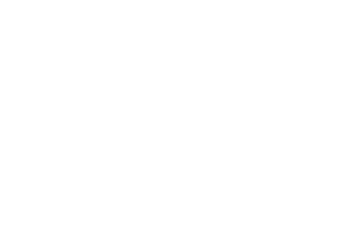

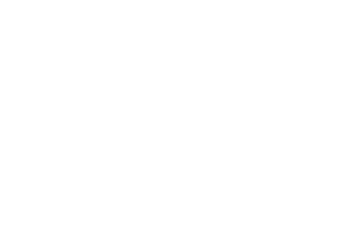

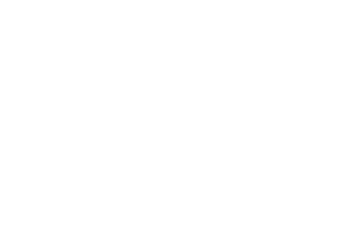

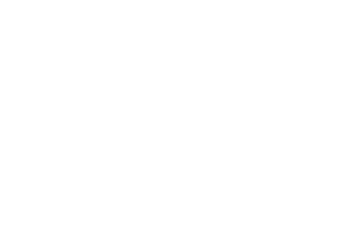

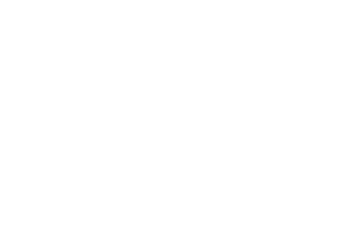

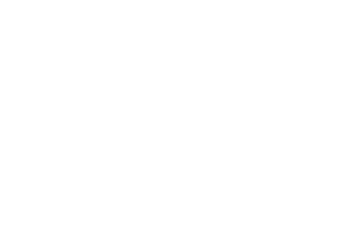

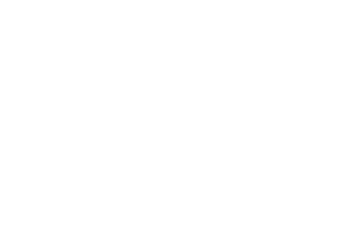

In [35]:
# Root - base window layer

root = Tk()
root.title("Uninformed Searches")  # sets window title
root.resizable(False, False)  # prevents window resizing to maintain spacing

# Label frames - grooved boxes for organisation

input_lframe = LabelFrame(root, text="State Space")
input_lframe.pack(side=LEFT, fill=BOTH, expand="yes", padx=10, pady=10)

graph_lframe = LabelFrame(root, text="Graph")
graph_lframe.pack(side=RIGHT, fill=BOTH, expand="yes", padx=10, pady=10)

# Buttons - clickable objects for functionality

vertex_button = Button(
    input_lframe, text="Set", width=8, height=2, command=set_vertices,
)
vertex_button.grid(row=22, column=0)

load_button = Button(
    input_lframe, text="Restore", width=8, height=2, command=load_problem,
)
load_button.grid(row=22, column=4)

save_button = Button(input_lframe, text="Backup", width=8, height=2, command=save_problem,state=DISABLED,)
save_button.grid(row=22, column=3)

draw_graph = Button(graph_lframe, text="Draw", width=8, height=2 ,command=draw_state)
draw_graph.grid(row=1, column=3)


# Labels - text areas for user feedback

vertex_label = Label(input_lframe, text="Vertices", width=10, height=2)
vertex_label.grid(row=0, column=0, padx=10)

edge_label = Label(input_lframe, text="Edges", width=10, height=2)
edge_label.grid(row=0, column=2, columnspan=4, padx=10)

# ENTRY - fields for user input

## layout variables

entry_width = 10

entry_padx = 10  # x padding for vertex and edge entry fields
entry_pady = 5  # y padding for vertex and edge entry fields

## vertices

## list for all vertex entry widgets
vertex_list = []

## loop to create 20 vertex entry widget
for i in range(20):
    vertex_list.append(Entry(input_lframe,width = entry_width))

## loop to create and place all vertex entry widgets
i=2
for entry in vertex_list:
    entry.grid(row=i, column=0, padx= entry_padx, pady = entry_pady)  
    i+=1
    

## edges

## list for all edge entry widgets
edge_list = []

## loop to create 60 edge entry widget
for i in range(80):
    edge_list.append(Entry(input_lframe,width = entry_width))

## loop to create and place all edge entry widgets

k=2
j=2    
for entry in edge_list:
    entry.grid(row=k, column=j, padx= entry_padx, pady = entry_pady)
    if j == 5:
        j=2
        k+=1
    else:
        j+=1



# Seperators
input_divider = ttk.Separator(master=input_lframe, orient=VERTICAL)
input_divider.grid(row=1, column=1, rowspan=20, ipady=285, padx=0)

# LABELS - text areas for user feedback

## graph labelframe

algorithm_label = Label(graph_lframe, text="Algorithm:")
algorithm_label.grid(row=0, column=0, padx=10, pady=10) 

start_label = Label(graph_lframe, text="Initial Node:")
start_label.grid(row=0, column=1, padx=10, pady=10) 

end_label = Label(graph_lframe, text="Goal Node:")
end_label.grid(row=0, column=2, padx=10, pady=10)  


number_edges = Label(graph_lframe, text="Total edges:   ")
number_edges.grid(row=5, column=0, pady=10) 

number_vertices = Label(graph_lframe, text="Total vertcies:   ")
number_vertices.grid(row=5, column=1, pady=10) 


## DROPDOWN MENU - 

algorithm_choice = StringVar()
algorithm_cbox = ttk.Combobox(graph_lframe, textvariable=algorithm_choice)
algorithm_cbox['values'] = (' Breadth First Search', ' Depth First Search',' Depth Limited Search',' Iterative Deepening Depth First Search')
algorithm_cbox.grid(row=1, column=0, padx=10, pady=10) 

start_choice = StringVar()
start_cbox = ttk.Combobox(graph_lframe, textvariable=start_choice)
start_cbox['values'] = ()
start_cbox.grid(row=1, column=1, padx=10, pady=10) 

end_choice = StringVar()
end_cbox = ttk.Combobox(graph_lframe, textvariable=end_choice)
end_cbox['values'] = ()
end_cbox.grid(row=1, column=2, padx=10, pady=10)

# Figures - drawing area for graphs

graph_figure = Figure(figsize=(10, 7))
graph_figure.set_facecolor("#f0f0f0")

# Subplots

graph_plot = graph_figure.add_subplot(111)  # creates graph subplot
graph_plot.axis("off")

# Canvas - area for holding figures

graph_canvas = FigureCanvasTkAgg(graph_figure, graph_lframe)
graph_canvas.get_tk_widget().grid(row=2, column=0, columnspan=4, pady=0, padx=0)

# GUI Loop - to start the GUI draw_graph

root.mainloop()  # starts main GUI loop